<a href="https://colab.research.google.com/github/bhardwajshivam/Vector-databases/blob/main/Approximate_nearest_vectors_neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Nearest Neighbors

In [18]:
!pip install utils

In [19]:
from random import random, randint
from math import floor, log
import networkx as nx
import numpy as np
import matplotlib as mtplt
from matplotlib import pyplot as plt
from utils import *

vec_num = 40 # Number of vectors (nodes)
dim = 2 ## Dimention. Set to be 2. All the graph plots are for dim 2. If changed, then plots should be commented.
m_nearest_neighbor = 2 # M Nearest Neigbor used in construction of the Navigable Small World (NSW)

vec_pos = np.random.uniform(size=(vec_num, dim))

In [20]:
import numpy as np
import networkx as nx
from random import random, randint
from math import floor, log
np.random.seed(44)

def nearest_neigbor(vec_pos,query_vec):
    nearest_neighbor_index = -1
    nearest_dist = float('inf')

    nodes = []
    edges = []
    for i in range(np.shape(vec_pos)[0]):
        nodes.append((i,{"pos": vec_pos[i,:]}))
        if i<np.shape(vec_pos)[0]-1:
            edges.append((i,i+1))
        else:
            edges.append((i,0))

        dist = np.linalg.norm(query_vec-vec_pos[i])
        if dist < nearest_dist:
            nearest_neighbor_index = i
            nearest_dist = dist

    G_lin = nx.Graph()
    G_lin.add_nodes_from(nodes)
    G_lin.add_edges_from(edges)

    nodes = []
    nodes.append(("*",{"pos": vec_pos[nearest_neighbor_index,:]}))
    G_best = nx.Graph()
    G_best.add_nodes_from(nodes)
    return G_lin, G_best

In [21]:
def layer_num(max_layers: int):
    # new element's topmost layer: notice the normalization by mL
    mL = 1.5
    layer_i = floor(-1 * log(random()) * mL)
    # ensure we don't exceed our allocated layers.
    layer_i = min(layer_i, max_layers-1)
    return layer_i
    #return randint(0,max_layers-1)

In [22]:
def construct_HNSW(vec_pos,m_nearest_neighbor):
    max_layers = 4

    vec_num = np.shape(vec_pos)[0]
    dist_mat = np.zeros((vec_num,vec_num))

    for i in range(vec_num):
        for j in range(i,vec_num):
            dist = np.linalg.norm(vec_pos[i,:]-vec_pos[j,:])
            dist_mat[i,j] = dist
            dist_mat[j,i] = dist

    node_layer = []
    for i in range(np.shape(vec_pos)[0]):
        node_layer.append(layer_num(max_layers))

    max_num_of_layers = max(node_layer) + 1 ## layer indices start from 0
    GraphArray = []
    for layer_i in range(max_num_of_layers):
        nodes = []
        edges = []
        edges_nn = []
        for i in range(np.shape(vec_pos)[0]): ## Number of Vectors
            if node_layer[i] >= layer_i:
                nodes.append((i,{"pos": vec_pos[i,:]}))

        G = nx.Graph()
        G.add_nodes_from(nodes)

        pos=nx.get_node_attributes(G,'pos')

        for i in range (len(G.nodes)):
            node_i = nodes[i][0]
            nearest_edges = -1
            nearest_distances = float('inf')
            candidate_edges = range(0,i)
            candidate_edges_indices = []

            #######################
            for j in candidate_edges:
                node_j = nodes[j][0]
                candidate_edges_indices.append(node_j)

            dist_from_node = dist_mat[node_i,candidate_edges_indices]
            num_nearest_neighbor = min(m_nearest_neighbor,i) ### Add note comment

            if num_nearest_neighbor > 0:
                indices = np.argsort(dist_from_node)
                for nn_i in range(num_nearest_neighbor):
                        edges_nn.append((node_i,candidate_edges_indices[indices[nn_i]]))

            for j in candidate_edges:
                node_j = nodes[j][0]
                dist = np.linalg.norm(pos[node_i]-pos[node_j])
                if dist < nearest_distances:
                    nearest_edges = node_j
                    nearest_distances = dist

            if nearest_edges != -1:
                edges.append((node_i,nearest_edges))

        G.add_edges_from(edges_nn)

        GraphArray.append(G)

    return GraphArray


In [23]:
## Search the Graph
def search_HNSW(GraphArray,G_query):
    max_layers = len(GraphArray)
    G_top_layer = GraphArray[max_layers - 1]
    num_nodes = G_top_layer.number_of_nodes()
    entry_node_r = randint(0,num_nodes-1)
    nodes_list = list(G_top_layer.nodes)
    entry_node_index = nodes_list[entry_node_r]
    #entry_node_index = 26

    SearchPathGraphArray = []
    EntryGraphArray = []
    for l_i in range(max_layers):
        layer_i = max_layers - l_i - 1
        G_layer = GraphArray[layer_i]

        G_entry = nx.Graph()
        nodes = []
        p = G_layer.nodes[entry_node_index]['pos']
        nodes.append((entry_node_index,{"pos": p}))
        G_entry.add_nodes_from(nodes)

        nearest_node_layer = entry_node_index
        nearest_distance_layer = np.linalg.norm( G_layer.nodes[entry_node_index]['pos'] - G_query.nodes['Q']['pos'])
        current_node_index = entry_node_index

        G_path_layer = nx.Graph()
        nodes_path = []
        p = G_layer.nodes[entry_node_index]['pos']
        nodes_path.append((entry_node_index,{"pos": p}))

        cond = True
        while cond:
            nearest_node_current = -1
            nearest_distance_current = float('inf')
            for neihbor_i in G_layer.neighbors(current_node_index):
                vec1 = G_layer.nodes[neihbor_i]['pos']
                vec2 = G_query.nodes['Q']['pos']
                dist = np.linalg.norm( vec1 - vec2)
                if dist < nearest_distance_current:
                    nearest_node_current = neihbor_i
                    nearest_distance_current = dist

            if nearest_distance_current < nearest_distance_layer:
                nearest_node_layer = nearest_node_current
                nearest_distance_layer = nearest_distance_current
                nodes_path.append((nearest_node_current,{"pos": G_layer.nodes[nearest_node_current]['pos']}))
            else:
                cond = False

        entry_node_index = nearest_node_layer

        G_path_layer.add_nodes_from(nodes_path)
        SearchPathGraphArray.append(G_path_layer)
        EntryGraphArray.append(G_entry)

    SearchPathGraphArray.reverse()
    EntryGraphArray.reverse()

    return SearchPathGraphArray, EntryGraphArray



## Query vector

In [24]:
## Query
query_vec = [0.5, 0.5]

nodes = []
nodes.append(("Q",{"pos": query_vec}))

G_query = nx.Graph()
G_query.add_nodes_from(nodes)

print("nodes = ", nodes, flush=True)

pos_query=nx.get_node_attributes(G_query,'pos')

nodes =  [('Q', {'pos': [0.5, 0.5]})]


## Brute Force



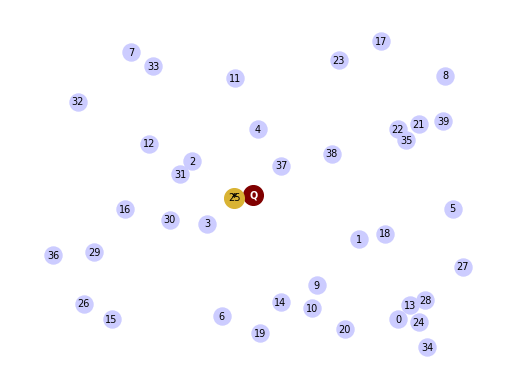

In [25]:
(G_lin, G_best) = nearest_neigbor(vec_pos,query_vec)

pos_lin=nx.get_node_attributes(G_lin,'pos')
pos_best=nx.get_node_attributes(G_best,'pos')

fig, axs = plt.subplots()

nx.draw(G_lin, pos_lin, with_labels=True, node_size=150, node_color=[[0.8,0.8,1]], width=0.0, font_size=7, ax = axs)
nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.5,0,0]], font_color='white', width=0.5, font_size=7, font_weight='bold', ax = axs)
nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)

## HSNW - Hierarchical Navigable Small World Search Construction

layer_i =  3


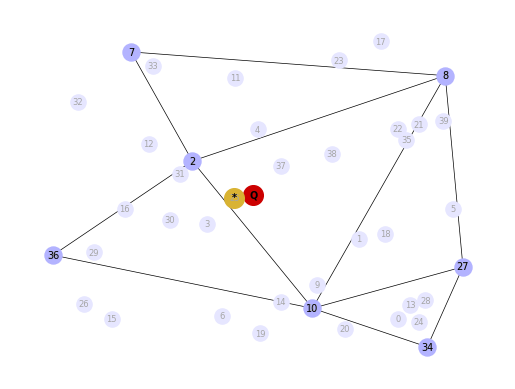

layer_i =  2


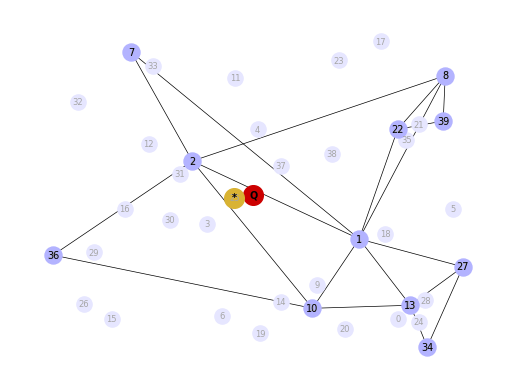

layer_i =  1


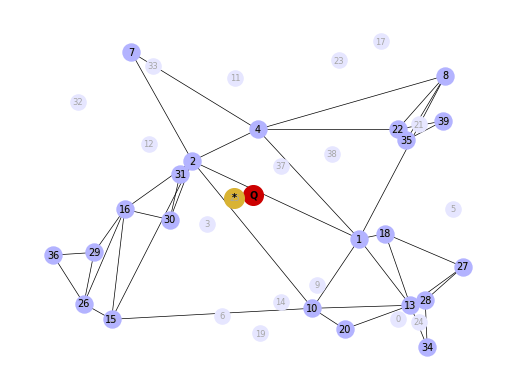

layer_i =  0


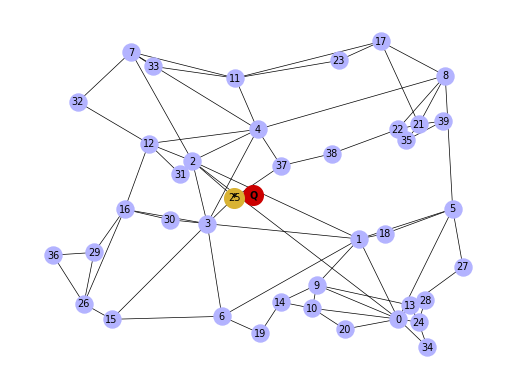

In [26]:
GraphArray = construct_HNSW(vec_pos,m_nearest_neighbor)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)

    if layer_i>0:
        pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
        nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=150, node_color=[[0.7,0.7,1]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.8,0,0]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    plt.show()

## HSNW Search

layer_i =  3


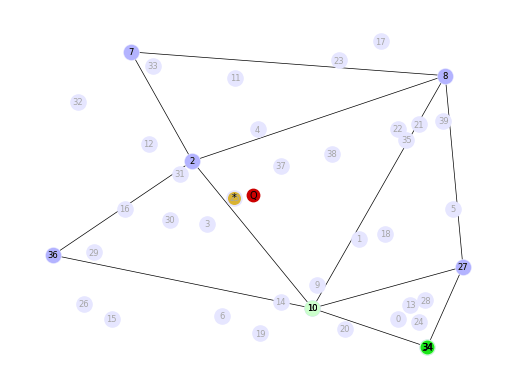

layer_i =  2


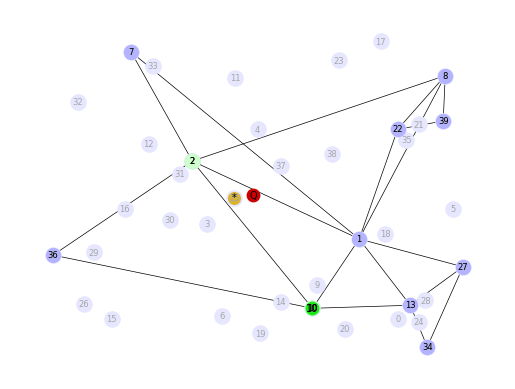

layer_i =  1


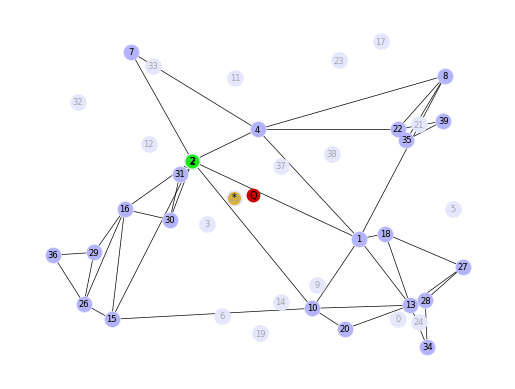

layer_i =  0


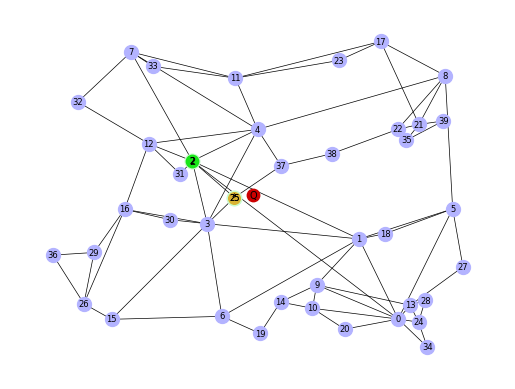

In [27]:
(SearchPathGraphArray, EntryGraphArray) = search_HNSW(GraphArray,G_query)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)
    G_path_layer = SearchPathGraphArray[layer_i]
    pos_path = nx.get_node_attributes(G_path_layer,'pos')
    G_entry = EntryGraphArray[layer_i]
    pos_entry = nx.get_node_attributes(G_entry,'pos')

    if layer_i>0:
            pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
            nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=100, node_color=[[0.7,0.7,1]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_path_layer, pos_path, with_labels=True, node_size=110, node_color=[[0.8,1,0.8]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=80, node_color=[[0.8,0,0]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=70, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_entry, pos_entry, with_labels=True, node_size=80, node_color=[[0.1,0.9,0.1]], width=0.5, font_size=7, ax = axs)
    plt.show()

## Pure Vector Search

In [30]:
!pip install weaviate-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-

In [31]:
import weaviate, json
from weaviate import EmbeddedOptions

client = weaviate.Client(
    embedded_options=EmbeddedOptions(),
)

client.is_ready()

Binary /root/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.23.7/weaviate-v1.23.7-Linux-amd64.tar.gz
Started /root/.cache/weaviate-embedded: process ID 14317


True

In [32]:
# resetting the schema. CAUTION: This will delete your collection
# if client.schema.exists("MyCollection"):
#     client.schema.delete_class("MyCollection")

schema = {
    "class": "MyCollection",
    "vectorizer": "none",
    "vectorIndexConfig": {
        "distance": "cosine" # let's use cosine distance
    },
}

client.schema.create_class(schema)

print("Successfully created the schema.")

Successfully created the schema.


## Import the data

In [33]:
data = [
   {
      "title": "First Object",
      "foo": 99,
      "vector": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   },
   {
      "title": "Second Object",
      "foo": 77,
      "vector": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   },
   {
      "title": "Third Object",
      "foo": 55,
      "vector": [0.3, 0.1, -0.1, -0.3, -0.5, -0.7]
   },
   {
      "title": "Fourth Object",
      "foo": 33,
      "vector": [0.4, 0.41, 0.42, 0.43, 0.44, 0.45]
   },
   {
      "title": "Fifth Object",
      "foo": 11,
      "vector": [0.5, 0.5, 0, 0, 0, 0]
   },
]

In [34]:
client.batch.configure(batch_size=10)  # Configure batch

# Batch import all objects
# yes batch is an overkill for 5 objects, but it is recommended for large volumes of data
with client.batch as batch:
  for item in data:

      properties = {
         "title": item["title"],
         "foo": item["foo"],
      }

      # the call that performs data insert
      client.batch.add_data_object(
         class_name="MyCollection",
         data_object=properties,
         vector=item["vector"] # your vector embeddings go here
      )


In [35]:
# Check number of objects
response = (
    client.query
    .aggregate("MyCollection")
    .with_meta_count()
    .do()
)

print(response)

{'data': {'Aggregate': {'MyCollection': [{'meta': {'count': 5}}]}}}


## Query Weavite: Vector search

In [36]:
response = (
    client.query
    .get("MyCollection", ["title"])
    .with_near_vector({
        "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
    })
    .with_limit(2) # limit the output to only 2
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "title": "Second Object"
  },
  {
    "title": "Fourth Object"
  }
]


In [37]:
response = (
    client.query
    .get("MyCollection", ["title"])
    .with_near_vector({
        "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
    })
    .with_limit(2) # limit the output to only 2
    .with_additional(["distance", "vector, id"])
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "_additional": {
      "distance": 0.6506307,
      "id": "7d3d2b17-cd34-4abd-b582-0295f4fb469c",
      "vector": [
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7
      ]
    },
    "title": "Second Object"
  },
  {
    "_additional": {
      "distance": 0.8072029,
      "id": "7ec877c5-d5f1-4a10-9b3b-55edc8e431ca",
      "vector": [
        0.4,
        0.41,
        0.42,
        0.43,
        0.44,
        0.45
      ]
    },
    "title": "Fourth Object"
  }
]


## Vector Search with filters


In [38]:
response = (
    client.query
    .get("MyCollection", ["title", "foo"])
    .with_near_vector({
        "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
    })
    .with_additional(["distance, id"]) # output the distance of the query vector to the objects in the database
    .with_where({
        "path": ["foo"],
        "operator": "GreaterThan",
        "valueNumber": 44
    })
    .with_limit(2) # limit the output to only 2
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "_additional": {
      "distance": 0.6506307,
      "id": "7d3d2b17-cd34-4abd-b582-0295f4fb469c"
    },
    "foo": 77,
    "title": "Second Object"
  },
  {
    "_additional": {
      "distance": 0.8284496,
      "id": "f84f0474-85a3-48da-9570-df17bcb58114"
    },
    "foo": 99,
    "title": "First Object"
  }
]



## nearObject Example


In [39]:
response = (
    client.query
    .get("MyCollection", ["title"])
    .with_near_object({ # the id of the the search object
        "id": result[0]['_additional']['id']
    })
    .with_limit(3)
    .with_additional(["distance"])
    .do()
)

result = response["data"]["Get"]["MyCollection"]
print(json.dumps(result, indent=2))

[
  {
    "_additional": {
      "distance": 0
    },
    "title": "Second Object"
  },
  {
    "_additional": {
      "distance": 0.051573694
    },
    "title": "Fourth Object"
  },
  {
    "_additional": {
      "distance": 0.06506646
    },
    "title": "First Object"
  }
]
